# <center> Naive Bayes and Logistic Classifiers </center>
### <div align=right> Made by:</div>
**<div align=right>Ihor Markevych</div>**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown

## Problem 1

### (a)  
  
$$f(x)=x^2+6x$$
$$\frac{df(x)}{dx}=2x+6$$
$$\frac{df(x)}{dx}=0=>2x+6=0=>x=-3$$

### (b)

In [2]:
def gradient(f, x, *args, **kwargs):
    res = []
    if np.array(x).shape == ():
        h = x * 1e-10 ** (1 / 3) if x != 0 else 1e-10
        return (f(x + h, *args, **kwargs) - f(x - h, *args, **kwargs)) / 2 / h
    
    x = list(x)     
    for i, xi in enumerate(x):
        h = xi * 1e-10 ** (1 / 3) if xi != 0 else 1e-10
        res.append((f(np.array(x[:i] + [x[i] + h] + x[(i + 1):]), *args, **kwargs) 
                   - f(np.array(x[:i]+ [x[i] - h] + x[(i + 1):]), *args, **kwargs)) / 2 / h)
    return np.array(res)

def gradientDescent(f, initX = None, 
                    lr=0.1, maxiters=1e5, eps=1e-6, *args, **kwargs):
    if initX is None:
        x = np.random.uniform(-100, 100)
    else:
        x = initX
    i = 0
    while i < maxiters and np.linalg.norm(gradient(f, x, *args, **kwargs)) > eps:
        i += 1
        x = x - lr * gradient(f, x, *args, **kwargs)
    return x

In [3]:
def f(x):
    return x ** 2 + 6 * x

gradientDescent(f)

-3.0000004771381694

### Comparing different learning rates

In [4]:
def gradientDescentWithHist(f, initX = None, 
                    lr=0.1, maxiters=1e5, eps=1e-6, *args, **kwargs):
    histX = []
    if initX is None:
        x = np.random.uniform(-100, 100)
    else:
        x = initX
    i = 0
    while i < maxiters and np.linalg.norm(gradient(f, x, *args, **kwargs)) > eps:
        i += 1
        histX.append(x)
        x = x - lr * gradient(f, x, *args, **kwargs)
    return x, histX

In the following cell we will demonstrate effects of different learning rates:
- if learning rate is set too high, method will not converge;
- if learning rate is set appropriatly, method will converge quickly;
- if learning rate is set too small, method will converge, but slow.

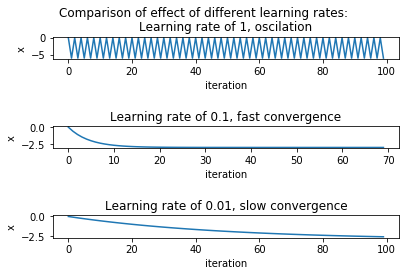

In [5]:
fig = plt.figure()

plt.suptitle('Comparison of effect of different learning rates:')

plt.subplot(3, 1, 1)
plt.title('Learning rate of 1, oscilation')
plt.xlabel('iteration')
plt.ylabel('x')
histX = gradientDescentWithHist(f, initX = 0, lr=1, maxiters=100)[1]
plt.plot([x for x in range(len(histX))], histX)

plt.subplot(3, 1, 2)
plt.title('Learning rate of 0.1, fast convergence')
plt.xlabel('iteration')
plt.ylabel('x')
histX = gradientDescentWithHist(f, initX = 0, lr=0.1, maxiters=100)[1]
plt.plot([x for x in range(len(histX))], histX)

plt.subplot(3, 1, 3)
plt.title('Learning rate of 0.01, slow convergence')
plt.xlabel('iteration')
plt.ylabel('x')
histX = gradientDescentWithHist(f, initX = 0, lr=0.01, maxiters=100)[1]
plt.plot([x for x in range(len(histX))], histX)

fig.tight_layout(pad=2.0)
plt.show()

## Problem 2

In [6]:
data = pd.read_csv('Oring.csv')

In [7]:
data

,Temp,Failure
0,53,1
1,56,1
2,57,1
3,63,0
4,66,0
5,67,0
6,67,0
7,67,0
8,68,0
9,69,0


Note: in the following implementation the next formulas were used:  
$\mu = \frac{\sum_{i=1}^N x}{N}$  
$\sigma = \sqrt{\frac{\sum_{i=1}^N (x-\mu)^2} {N-1}}$  
Commonly, for $\sigma$ estimator $\sqrt{\frac{\sum_{i=1}^N (x-\mu)^2} {N}}$ is used. However, to make statistical estimation not only unbiased, but also efficient, we have used $N-1$. Usually there is no significant difference between those estimates because of big sample size, but in our case sample size is small and estimations vary.

In [8]:
class Normalizer:
    def fit(self, data):
        self.mu = np.average(data)
        self.sigma = (sum((data - self.mu) ** 2) / (len(data) - 1)) ** 0.5
        
    def scale(self, data):
        return (data - self.mu) / self.sigma
    
    def fitAndScale(self, data):
        self.fit(data)
        return self.scale(data)

In [9]:
norm = Normalizer()
trainX = norm.fitAndScale(data['Temp'])
trainY = data['Failure']

In [10]:
trainX

0    -2.293007
1    -1.886366
2    -1.750818
3    -0.937535
4    -0.530893
5    -0.395346
6    -0.395346
7    -0.395346
8    -0.259799
9    -0.124252
10    0.011296
11    0.011296
12    0.011296
13    0.011296
14    0.282390
15    0.417937
16    0.689032
17    0.689032
18    0.824579
19    0.824579
20    1.095673
21    1.231221
22    1.366768
23    1.502315
Name: Temp, dtype: float64

Next, we construct the logistic regression model with objective function:
$$J(\mathbf{w}) = -\frac{1}{N}\sum_{n=1}^{N} (y_n \text{log}(h_{\mathbf{w}}(\mathbf{x}_n)) + (1 - y_n) \text{log}(1 - h_{\mathbf{w}}(\mathbf{x}_n)))$$. 
Here $(\mathbf{x}_n, y_n)_{n=1}^{N}$ is the collection of training data and $h_{\mathbf{w}}(\mathbf{x}_n) = \frac{1}{1+e^{-\langle \mathbf{w}, \mathbf{x}_n\rangle}}$.

Note: this objective is equivalent to Maximum Conditional Likelihood, as
$$argmax(\sum_{n=1}^{N} (y_n \text{log}(h_{\mathbf{w}}(\mathbf{x}_n)) + (1 - y_n) \text{log}(1 - h_{\mathbf{w}}(\mathbf{x}_n)))) = argmin(-\sum_{n=1}^{N} (y_n \text{log}(h_{\mathbf{w}}(\mathbf{x}_n)) + (1 - y_n) \text{log}(1 - h_{\mathbf{w}}(\mathbf{x}_n))))=argmin(-\frac{1}{N}\sum_{n=1}^{N} (y_n \text{log}(h_{\mathbf{w}}(\mathbf{x}_n)) + (1 - y_n) \text{log}(1 - h_{\mathbf{w}}(\mathbf{x}_n))))$$

Often regularization term is introduced to prevent overfitting. With such regularization, the objective gets slightly modified to $J(\mathbf{w}) = -\frac{1}{N} \sum_{n=1}^{N} (y_n \text{log}(h_{\mathbf{w}}(\mathbf{x}_n)) + (1 - y_n) \text{log}(1 - h_{\mathbf{w}}(\mathbf{x}_n))) + \frac{\lambda}{2N} ||\mathbf{w}[1:]||_{2}^{2}$, where $\lambda$ is the regularization parameter. Note: $w_0$, bias term, is not included in regularization term.  
  
Since the objective function is convex, the value of it decreases with every iteration of gradient descent when the learning rate is set appropriately. When learning rate is too high, gradient of the objective function starts to osciallatate and no convergence is achieved.

In [11]:
class LogisticRegression:
        
    @staticmethod
    def sigmoid(weights, X):
        if isinstance(X, int) or isinstance(X, float):
            X = np.array([X])
        else:
            X = np.array(X)
        X = np.insert(X[:, None], 0, 1, axis=1)
        return 1 / (1 + np.exp(- X @ weights))
    
    @staticmethod
    def objectiveFunction(weights, X, y, regularizationCoefficient=0):
        return sum(- y * np.log(LogisticRegression.sigmoid(weights, X)) 
                   - (1 - y) * np.log(1 - LogisticRegression.sigmoid(weights, X))) / len(X) \
                + np.linalg.norm(weights[1:]) ** 2 * regularizationCoefficient / 2 / len(X)
    
    
    def __init__(self, lr = 0.1, regularizationCoefficient=0):
        self.lr = lr
        self.regularizationCoefficient = regularizationCoefficient
    
    def fit(self, X):
        self.w = np.zeros(np.array(X).reshape(-1,1).shape[1] + 1)
    
    def train(self, X, y):
        self.fit(X)
        self.w = gradientDescent(LogisticRegression.objectiveFunction, 
                                 lr=self.lr, initX=self.w, 
                                 X=X, y=y, regularizationCoefficient=self.regularizationCoefficient)
        
    def predictProb(self, X):
        return self.sigmoid(self.w, X)
    
    def predict(self, X):
        return int(self.predictProb(X) > 0.5)
    
    def showFormula(self):
        display(Markdown('$p(y=1|x)=\\frac{1}{1+e^{(' + str(self.w) + ', x)}}$'))

### Unregularized Logistic Regression

In [12]:
logR = LogisticRegression()
logR.train(trainX, trainY)
logR.showFormula()

$p(y=1|x)=\frac{1}{1+e^{([-1.10280355 -1.26390853], x)}}$

In [13]:
print(f"Model predicted {'failure' if logR.predict(norm.scale(31)) == 1 else 'no failure'} with probability {logR.predictProb(norm.scale(31))[0]}.")

Model predicted failure with probability 0.9961826447880249.


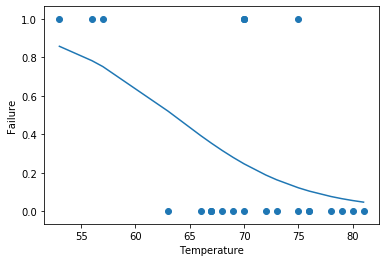

In [14]:
plt.scatter(data['Temp'], data['Failure'])
plt.xlabel('Temperature')
plt.ylabel('Failure')
plt.plot(data['Temp'], logR.predictProb(trainX))
plt.show()

### Regularized Logistic Regression with $\lambda=1$

In [15]:
logR = LogisticRegression(regularizationCoefficient=1)
logR.train(trainX, trainY)
logR.showFormula()

$p(y=1|x)=\frac{1}{1+e^{([-1.0263191  -0.95262766], x)}}$

In [16]:
print(f"Model predicted {'failure' if logR.predict(norm.scale(31)) == 1 else 'no failure'} with probability {logR.predictProb(norm.scale(31))[0]}.")

Model predicted failure with probability 0.9819932220960629.


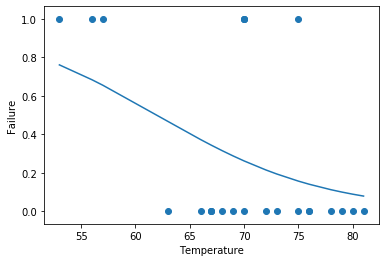

In [17]:
plt.scatter(data['Temp'], data['Failure'])
plt.xlabel('Temperature')
plt.ylabel('Failure')
plt.plot(data['Temp'], logR.predictProb(trainX))
plt.show()

Even despite model has a high probability of predicted label, this model can not be used to make predictions in real situations. The reason for this is small amount of data (28 samples), that should not be enough to built generalized model. Also, because of this sample size, we can't subset a test set to check our model on unseen data (we have checked it only on single sample (31,1)).